## The Data
We will be using a dataset recently published by RIOT games(Parent company who owns league of legends) on https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min


# From https://en.wikipedia.org/wiki/League_of_Legends
"League of Legends is a multiplayer online battle arena (MOBA) game in the three-dimensional isometric perspective. The game consists of two current running game modes: Summoner's Rift and Howling Abyss. The Crystal Scar and Twisted Treeline, maps corresponding to discontinued game modes, have since been removed. Camera perspective cannot be changed by a player, other than zooming and panning, thus whether the player spawns at the top or bottom bases will be fixed for the duration of the game. Players compete in matches, lasting anywhere from 20 to 50 minutes on average. In each game mode, teams work together to achieve a victory condition, typically destroying the core building (called the Nexus) in the enemy team's base after bypassing a line of defensive structures called turrets, or towers.."

## Our Goal
To analyze the given dataset in order to find the features that are most correlated with blueside winning and finding a machine learning model which best predicts the outcome of the game after 10 minutes game time.


In [1]:
# Importing all the necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Model Evaluations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

#clean up to remove duplicates from above
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv('high_diamond_ranked_10min.csv')
df.shape

(9879, 40)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [4]:
df.head(10)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
5,4475365709,1,18,0,0,5,3,6,1,1,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
6,4493010632,1,18,3,1,7,6,7,1,1,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
7,4496759358,0,16,2,0,5,13,3,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
8,4443048030,0,16,3,0,7,7,8,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0
9,4509433346,1,13,1,1,4,5,5,1,1,...,0,16605,6.8,18379,247,43,1548,1574,24.7,1660.5


In [5]:
# Removing the following to avoid colinearity. 
# Blue gold to Red gold imply golddifference, as well as gold/experience for towers being destroyed is included in gold/experience totals.
# Average level doesnt matter because we have included totalExperience
blue_col = ['blueDeaths','blueEliteMonsters','blueTowersDestroyed','blueAvgLevel','blueGoldDiff','blueExperienceDiff']

In [6]:
red_col = ['redDeaths','redEliteMonsters','redTowersDestroyed','redAvgLevel','redGoldDiff','redExperienceDiff']

In [7]:
df.drop(blue_col, axis=1,inplace=True)

In [8]:
df.drop(red_col, axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueDragons                   9879 non-null   int64  
 8   blueHeralds                   9879 non-null   int64  
 9   blueTotalGold                 9879 non-null   int64  
 10  blueTotalExperience           9879 non-null   int64  
 11  blueTotalMinionsKilled        9879 non-null   int64  
 12  blueTotalJungleMinionsKilled  9879 non-null   int64  
 13  blu

In [10]:
# Checking for Null Values
df.isna().sum()

gameId                          0
blueWins                        0
blueWardsPlaced                 0
blueWardsDestroyed              0
blueFirstBlood                  0
blueKills                       0
blueAssists                     0
blueDragons                     0
blueHeralds                     0
blueTotalGold                   0
blueTotalExperience             0
blueTotalMinionsKilled          0
blueTotalJungleMinionsKilled    0
blueCSPerMin                    0
blueGoldPerMin                  0
redWardsPlaced                  0
redWardsDestroyed               0
redFirstBlood                   0
redKills                        0
redAssists                      0
redDragons                      0
redHeralds                      0
redTotalGold                    0
redTotalExperience              0
redTotalMinionsKilled           0
redTotalJungleMinionsKilled     0
redCSPerMin                     0
redGoldPerMin                   0
dtype: int64

In [11]:
# Getting a list of only blue columns
blue_cols = [col for col in df.columns if 'blue' in col]
print(blue_cols)

['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueKills', 'blueAssists', 'blueDragons', 'blueHeralds', 'blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueCSPerMin', 'blueGoldPerMin']


In [12]:
# Removing columns that will produce a 1 or 0 value from the future pairplot
blue_cols = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueAssists', 'blueTotalGold', 'blueTotalExperience', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldPerMin']

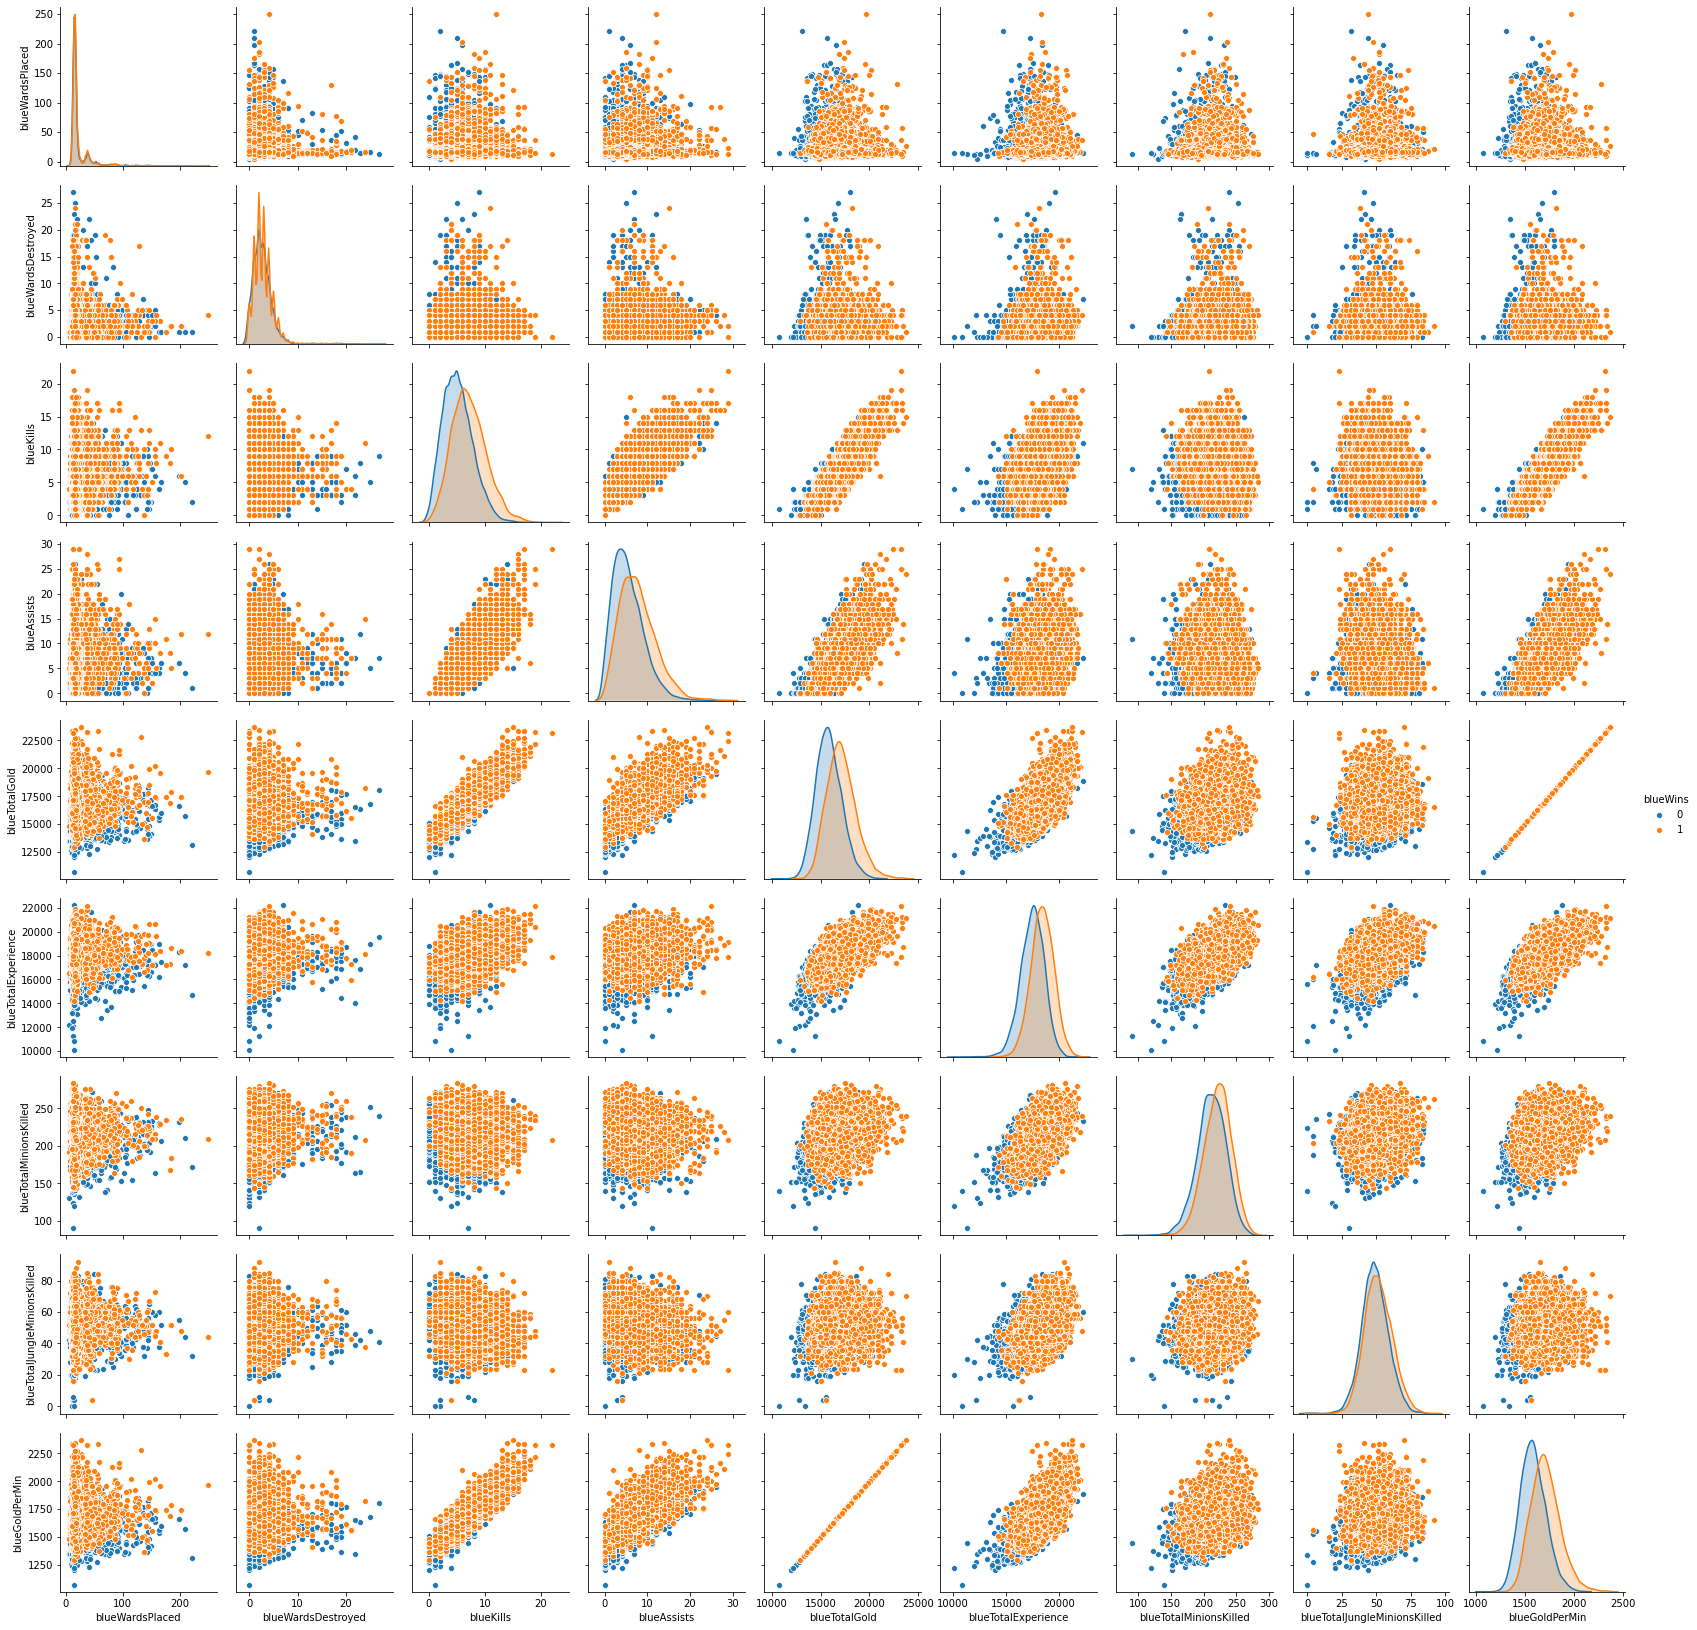

In [13]:
# Following import to hide pairplot warnings
import warnings
warnings.filterwarnings('ignore')

# Use of a pairplot to show relationship of blue team columns/features
sns.pairplot(data=df, vars=blue_cols, hue='blueWins')

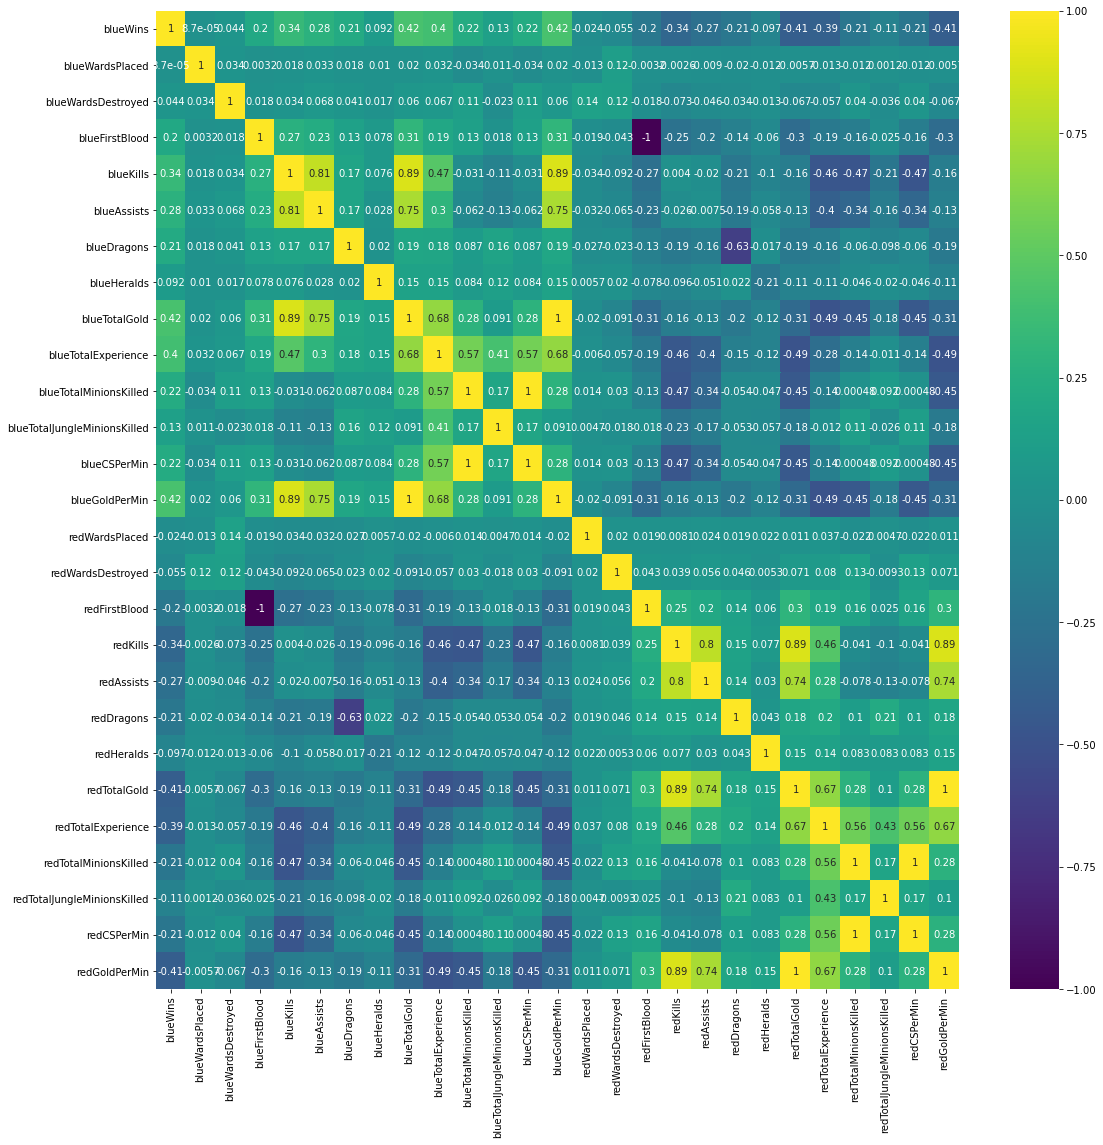

In [14]:
# Now we will look into the correlation of features 
plt.figure(figsize=(18,18))
sns.heatmap(df.drop('gameId', axis=1).corr(),annot=True,cmap='viridis');

In [15]:
# Creating a list of the more highly correlated features
blue_best_cols = []
for x in df.columns:
    if df['blueWins'].corr(df[x]) >= .2:
        blue_best_cols.append(x)

In [16]:
blue_best_cols

['blueWins',
 'blueFirstBlood',
 'blueKills',
 'blueAssists',
 'blueDragons',
 'blueTotalGold',
 'blueTotalExperience',
 'blueTotalMinionsKilled',
 'blueCSPerMin',
 'blueGoldPerMin']

In [17]:
# For local efficiency will be evaluating only blue features as predictors of blue victory
# Additionally, will be using only the best correlated features with blueWinning in our dataframe
df_blue = df[blue_best_cols]

In [18]:
df_blue.head(10)

,blueWins,blueFirstBlood,blueKills,blueAssists,blueDragons,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueCSPerMin,blueGoldPerMin
0,0,1,9,11,0,17210,17039,195,19.5,1721.0
1,0,0,5,5,0,14712,16265,174,17.4,1471.2
2,0,0,7,4,1,16113,16221,186,18.6,1611.3
3,0,0,4,5,0,15157,17954,201,20.1,1515.7
4,0,0,6,6,0,16400,18543,210,21.0,1640.0
5,1,0,5,6,1,15899,18161,225,22.5,1589.9
6,1,1,7,7,1,16874,16967,225,22.5,1687.4
7,0,0,5,3,0,15305,16138,209,20.9,1530.5
8,0,0,7,8,0,16401,18527,189,18.9,1640.1
9,1,1,4,5,1,15057,16805,220,22.0,1505.7


In [19]:
# train test split scale the set
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X = df_blue.drop("blueWins", axis=1)
y = df_blue['blueWins']
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Naive Bayes": GaussianNB()}

# Function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [21]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'Logistic Regression': 0.7054655870445344,
 'KNN': 0.6487854251012146,
 'Random Forest': 0.666497975708502,
 'Naive Bayes': 0.694838056680162}

## Quick Note:Random Forest has performed well and Naive Bayes contains almost no Hyperparameters to Tune.

In [22]:
# Function to quickly evaluate model without use of class_report
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [23]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 100, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Trying to improve Random Forest Model by using RandomizedSearch

In [24]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.4s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 60])},
                   verbose=True)

In [25]:
rs_rf.best_params_

{'n_estimators': 10,
 'min_samples_split': 18,
 'min_samples_leaf': 7,
 'max_depth': 5}

In [26]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_rf.predict(X_test)

# Evaluate the predictions
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 69.38%
Precision: 0.69
Recall: 0.70
F1 score: 0.70


In [27]:
y_probs = rs_rf.predict_proba(X_test)

y_probs[:10], len(y_probs)

(array([[0.66557789, 0.33442211],
        [0.29895064, 0.70104936],
        [0.25488754, 0.74511246],
        [0.28676624, 0.71323376],
        [0.71751088, 0.28248912],
        [0.80620487, 0.19379513],
        [0.05360805, 0.94639195],
        [0.42507395, 0.57492605],
        [0.48333258, 0.51666742],
        [0.39058171, 0.60941829]]),
 1976)

In [28]:
y_probs_positive = y_probs[:, 1]
y_probs_positive[:10]

array([0.33442211, 0.70104936, 0.74511246, 0.71323376, 0.28248912,
       0.19379513, 0.94639195, 0.57492605, 0.51666742, 0.60941829])

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)

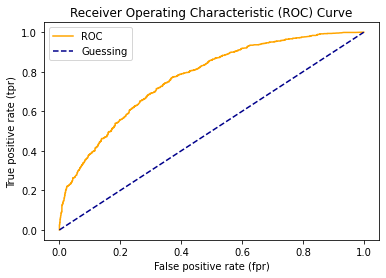

In [30]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positive rate (fpr)
    and true positive rate (tpr) of a model.
    """
    # Plot roc curve
    plt.plot(fpr, tpr, color="orange", label="ROC")
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Guessing")
    
    # Customize the plot
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

In [31]:
# Make predictions with tuned model
y_preds = rs_rf.predict(X_test)

In [32]:
y_preds

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [33]:
y_test

4818    0
952     1
9023    1
5212    1
7244    0
       ..
473     0
3071    1
3937    0
3032    0
5118    1
Name: blueWins, Length: 1976, dtype: int64

In [34]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       983
           1       0.69      0.70      0.70       993

    accuracy                           0.69      1976
   macro avg       0.69      0.69      0.69      1976
weighted avg       0.69      0.69      0.69      1976



# Improving Logistic Regression Model Using RandomizedSearch

In [35]:
# Tuning LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [36]:
# best hyperparameters
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 29.763514416313132}

In [37]:
rs_log_reg.score(X_test, y_test)

0.707995951417004

## Very good improvement after tuning Logistic Regression Model

In [38]:
# Make predictions with tuned model
y_preds = rs_log_reg.predict(X_test)

In [39]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71       983
           1       0.71      0.71      0.71       993

    accuracy                           0.71      1976
   macro avg       0.71      0.71      0.71      1976
weighted avg       0.71      0.71      0.71      1976



## Now that we have our Best Predictive Model, I will go over the Features Most correlated with Blue Side winning

In [40]:
# Getting the correlations with blueWinning from each feature in the dataframe
blue_corr=[]
for x in df_blue.drop('blueWins',axis=1).columns:
    blue_corr.append(df_blue['blueWins'].corr(df[x]))

In [41]:
blue_corr

[0.20176926438571072,
 0.3373576105342438,
 0.2766849645392132,
 0.21376769276290764,
 0.4172125582921805,
 0.39614070565143955,
 0.22490947260651542,
 0.2249094726065156,
 0.41721255829218035]

In [42]:
# Creating a Dictionary of the columns and their respective correlation with blueWinning
feature_dict = dict(zip(df_blue.drop('blueWins',axis=1).columns, blue_corr))
feature_dict

{'blueFirstBlood': 0.20176926438571072,
 'blueKills': 0.3373576105342438,
 'blueAssists': 0.2766849645392132,
 'blueDragons': 0.21376769276290764,
 'blueTotalGold': 0.4172125582921805,
 'blueTotalExperience': 0.39614070565143955,
 'blueTotalMinionsKilled': 0.22490947260651542,
 'blueCSPerMin': 0.2249094726065156,
 'blueGoldPerMin': 0.41721255829218035}

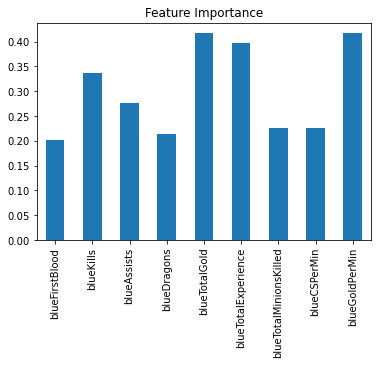

In [43]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False)

# From the above we see the Three most highly correlated features with blue side winning are
 * blueTotalGold
 * blueTotalExperience
 * blueGoldPerMin

### Much Like life, Leauge of Legends seems to follow the pattern of the more money and experience you have, the more likely you are to succeed.